# Learned data compression

useful blog:
https://blog.acolyer.org/2017/05/08/end-to-end-optimized-image-compression/

## Overview

    * Goal: lossy data compression
    * Challenge: Trade-off between rate and distortion

          rate: the expected number of bits needed to encode a sample
          distortion: the expected error in the reconstruction of the sample.
          Note: in Lossless, we only have rate

    * dataset: MNIST
    * Method : "END-TO-END OPTIMIZED IMAGE COMPRESSION"

## Setup

Install Tensorflow Compression via `pip`.

In [ ]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


Import library dependencies.

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


## Define the trainer model.


The training model consists of three parts:
  - the **analysis** (or encoder) transform:
        
        converting from the image into a latent space,
  - the **synthesis** (or decoder) transform:
  
        converting from the latent space back into image space, and
  - a **prior** and entropy model:
        
        modeling the marginal probabilities of the latents.

First, define the transforms:

### Analysis (encoder) Transform

In [3]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D( 20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),

      tf.keras.layers.Conv2D( 50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),

      tf.keras.layers.Flatten(),

      tf.keras.layers.Dense( 500, use_bias=True, activation="leaky_relu", name="fc_1"),

      tf.keras.layers.Dense( latent_dims, use_bias=True, activation=None, name="fc_2"),], name="analysis_transform")


In [4]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense( 500, use_bias=True, activation="leaky_relu", name="fc_1"),

      tf.keras.layers.Dense( 2450, use_bias=True, activation="leaky_relu", name="fc_2"),

      tf.keras.layers.Reshape((7, 7, 50)),

      tf.keras.layers.Conv2DTranspose( 20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),

      tf.keras.layers.Conv2DTranspose( 1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


### Trainer class

The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [5]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    ## in trainer, should consider 3 components: encode, decode, prior
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses.

    Step1:
      Ensure inputs are floats in the range (0, 1).

    Step2:
      x  --> encoder --> y
      y  --> Entropy --> y^ and rate
      y^ --> decoder --> x^

      rate and distortion --> loss function
    """
    ## step 1
    ##  self.compute_dtype is the desired data type for the computation.
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))


    ## Step 2
    ## encode
    ## prob_model (prob_dist, coding_rank, compression)
    ##    coding_rank: how many dimensions are grouped together to form a single unit for compression
    y = self.analysis_transform(x)

    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)

    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [6]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


And extract one image $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


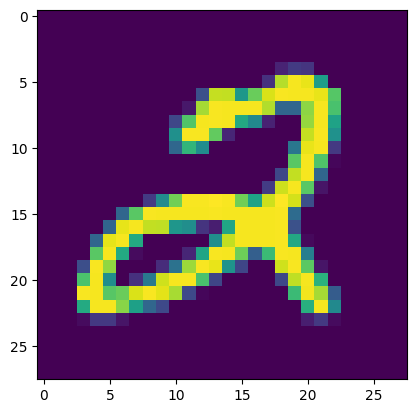

In [7]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [8]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[ 0.01614755 -0.06944998  0.0141878   0.0721685  -0.02062733 -0.04844383
   0.00878097 -0.1003072   0.04356039  0.04794359]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [9]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.5081025  -0.5150483   0.25657964  0.4761336   0.2527874  -0.2966453
  -0.36807916 -0.0700253   0.32646918  0.4217633 ]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

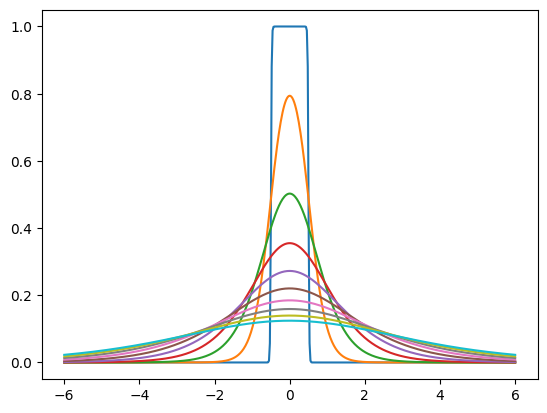

In [10]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [11]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.330082], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[-0.116767    0.31321436  0.26040375  0.33241466 -0.28652602 -0.00878242
   0.43599918 -0.29684076 -0.26684403  0.11404204]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17083237, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


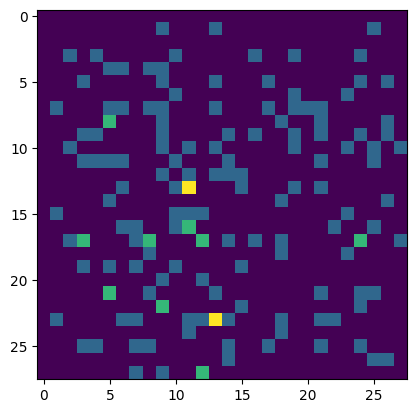

In [12]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [13]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [14]:
"""

  train Model >> to effect on
  ---------------------------
  train the encoder --> rate and distortion
  train the decoder --> distortion
  train the Entropy --> rate

"""
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  # instance the trainer
  trainer = MNISTCompressionTrainer(latent_dims)
  # compile
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [15]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 219.1083 - distortion_loss: 0.0596 - rate_loss: 99.9403 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 99.9360

469/469 [==============================] - 80s 165ms/step - loss: 219.1083 - distortion_loss: 0.0596 - rate_loss: 99.9403 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 99.9360 - val_loss: 176.7159 - val_distortion_loss: 0.0423 - val_rate_loss: 92.0706 - val_distortion_pass_through_loss: 0.0423 - val_rate_pass_through_loss: 92.0771
Epoch 2/15
469/469 [==============================] - 78s 166ms/step - loss: 164.7198 - distortion_loss: 0.0403 - rate_loss: 84.1094 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 84.1051 - val_loss: 155.9019 - val_distortion_loss: 0.0407 - val_rate_loss: 74.5280 - val_distortion_pass_through_loss: 0.0407 - val_rate_pass_through_loss: 74.5436
Epoch 3/15
469/469 [==============================] - 71s 151ms/step - loss: 149.4218 - distortion_loss: 0.0391 - rate_loss: 71.2561 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 71.2529 - val_loss: 143.8551 - val_distortion_loss: 0.0406 - val_rate_loss: 62.7387 - v

## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [16]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [17]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [18]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=1, compression=True, **kwargs)

  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)

  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)

  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [19]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [20]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0x9b430a992093
Number of bits actually needed to represent it: 41.26


Decompress the images back from the strings.

In [21]:
reconstructions = decompressor(strings)


Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


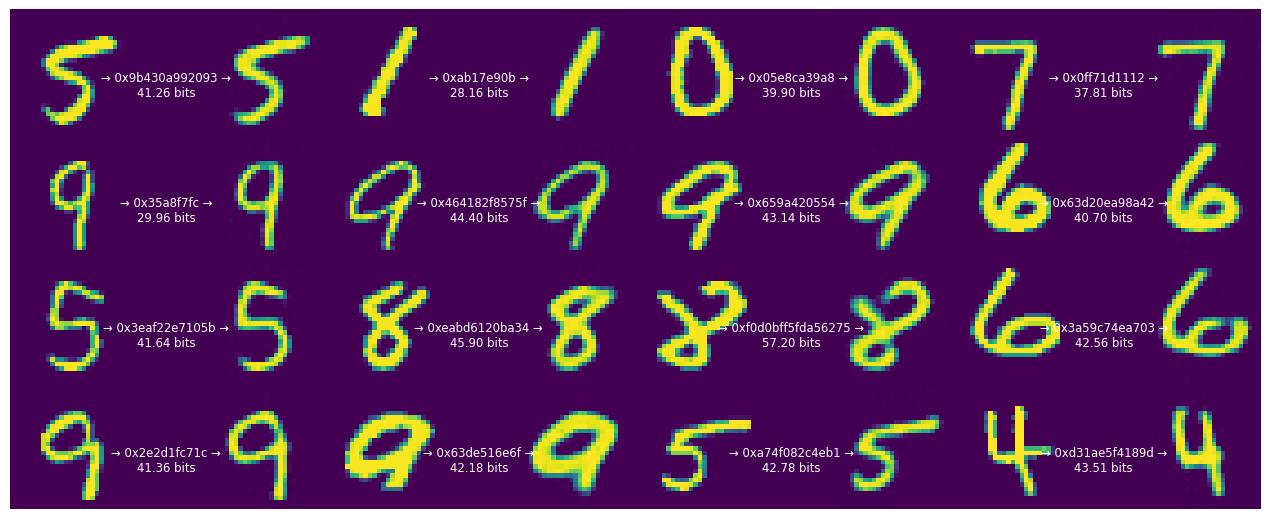

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 127.8852 - distortion_loss: 0.0708 - rate_loss: 92.5042 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 92.4978

469/469 [==============================] - 77s 161ms/step - loss: 127.8852 - distortion_loss: 0.0708 - rate_loss: 92.5042 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 92.4978 - val_loss: 107.4501 - val_distortion_loss: 0.0555 - val_rate_loss: 79.7216 - val_distortion_pass_through_loss: 0.0555 - val_rate_pass_through_loss: 79.7194
Epoch 2/15
469/469 [==============================] - 78s 167ms/step - loss: 97.2316 - distortion_loss: 0.0538 - rate_loss: 70.3478 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 70.3423 - val_loss: 86.2910 - val_distortion_loss: 0.0617 - val_rate_loss: 55.4382 - val_distortion_pass_through_loss: 0.0617 - val_rate_pass_through_loss: 55.4340
Epoch 3/15
469/469 [==============================] - 81s 173ms/step - loss: 81.1435 - distortion_loss: 0.0559 - rate_loss: 53.1755 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 53.1719 - val_loss: 72.0000 - val_distortion_loss: 0.0700 - val_rate_loss: 37.0078 - val_d

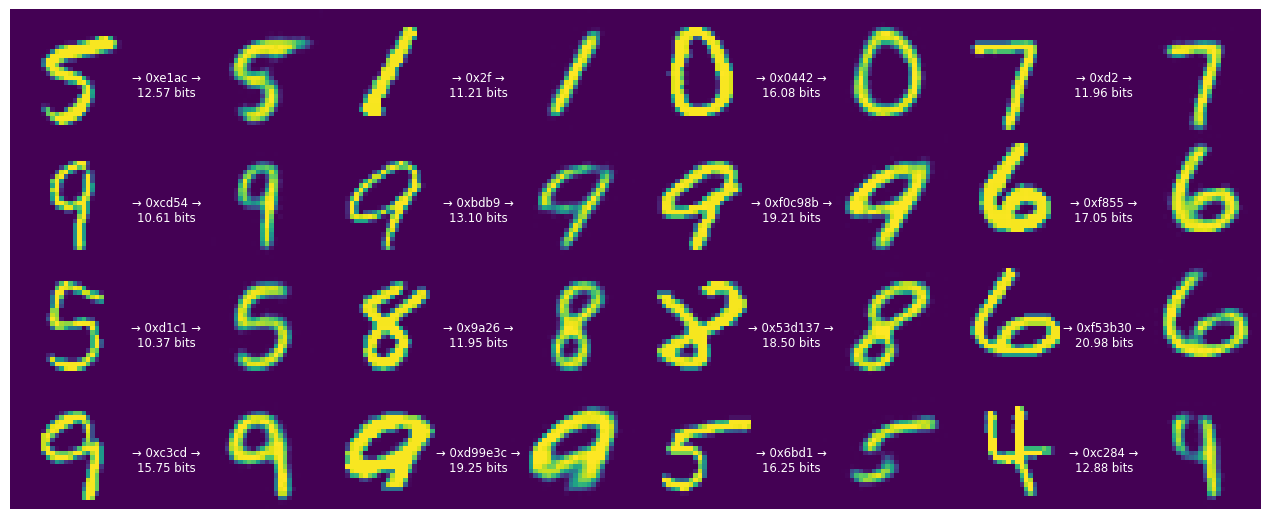

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 113.8702 - distortion_loss: 0.0762 - rate_loss: 91.0030 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 90.9964

469/469 [==============================] - 70s 145ms/step - loss: 113.8702 - distortion_loss: 0.0762 - rate_loss: 91.0030 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 90.9964 - val_loss: 95.9507 - val_distortion_loss: 0.0640 - val_rate_loss: 76.7414 - val_distortion_pass_through_loss: 0.0640 - val_rate_pass_through_loss: 76.7464
Epoch 2/15
469/469 [==============================] - 65s 138ms/step - loss: 85.6206 - distortion_loss: 0.0603 - rate_loss: 67.5319 - distortion_pass_through_loss: 0.0603 - rate_pass_through_loss: 67.5263 - val_loss: 73.6495 - val_distortion_loss: 0.0747 - val_rate_loss: 51.2387 - val_distortion_pass_through_loss: 0.0747 - val_rate_pass_through_loss: 51.2380
Epoch 3/15
469/469 [==============================] - 64s 137ms/step - loss: 68.6614 - distortion_loss: 0.0639 - rate_loss: 49.5031 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 49.4993 - val_loss: 58.4794 - val_distortion_loss: 0.0901 - val_rate_loss: 31.4431 - val_di

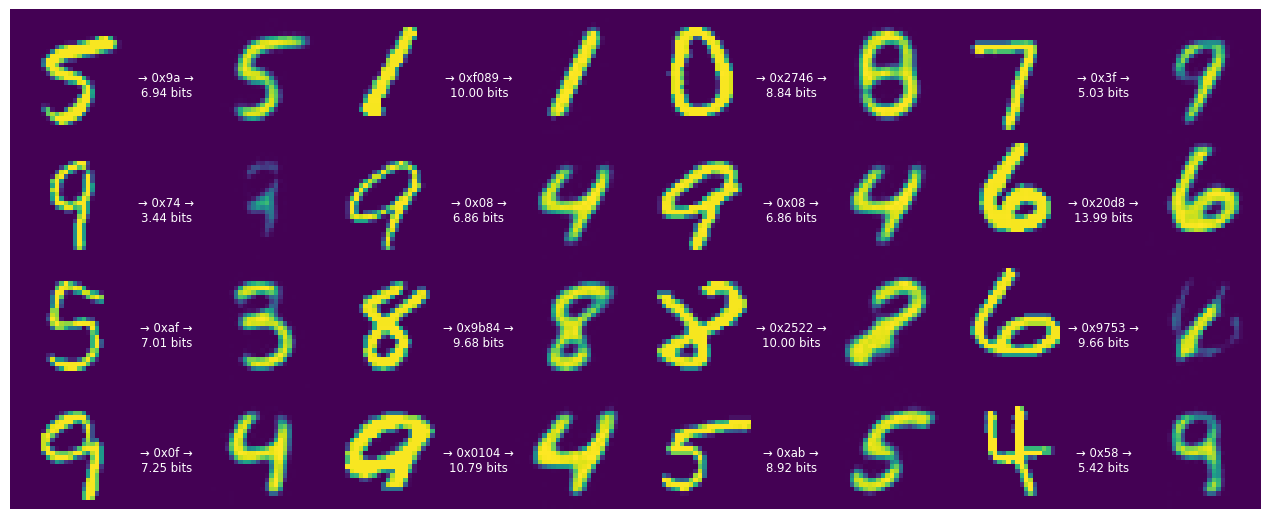

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [27]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

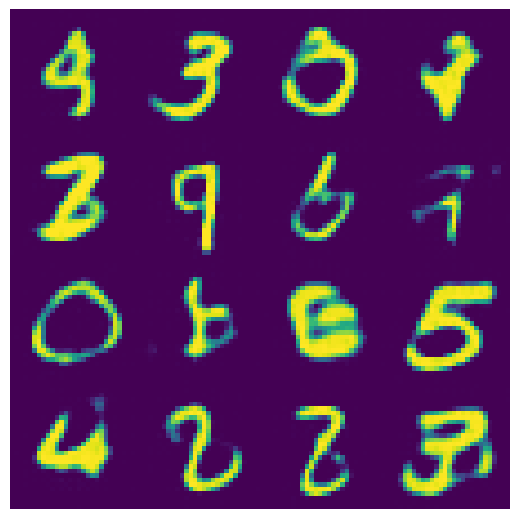

In [28]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
